# 1.1 Radial velocity analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023-2024 exercise 1

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 28.4.2024

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).


## (The absolute basics of) radial velocities

A planet orbiting a star causes the star to [move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity,
and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

![Doppler shift vs time](Doppler_Shift_vs_Time.svg "Doppler shift vs time")


A planet with a mass $M_\mathrm{p}$ orbiting a star with a mass $M_\star$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}},
$$

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$, and $M_\star$ we can solve for the minimum planetary mass $M_\mathrm{p} \sin i$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.


## (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a *parameter estimation* problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://ui.adsabs.harvard.edu/link_gateway/2018haex.bookE.149P/EPRINT_PDF) and the references therein.

## Initialisation

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import astropy.units as u

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, median
from astropy.table import Table
from astropy.timeseries import LombScargle
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [3]:
rv_data = Table.read('data/wasp_12b_yee_2019.dat', format='ascii.cds')

It's important to understand what sort of data we're dealing with, so we begin by displaying the table header and the five first rows.

In [4]:
rv_data[:5]  

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

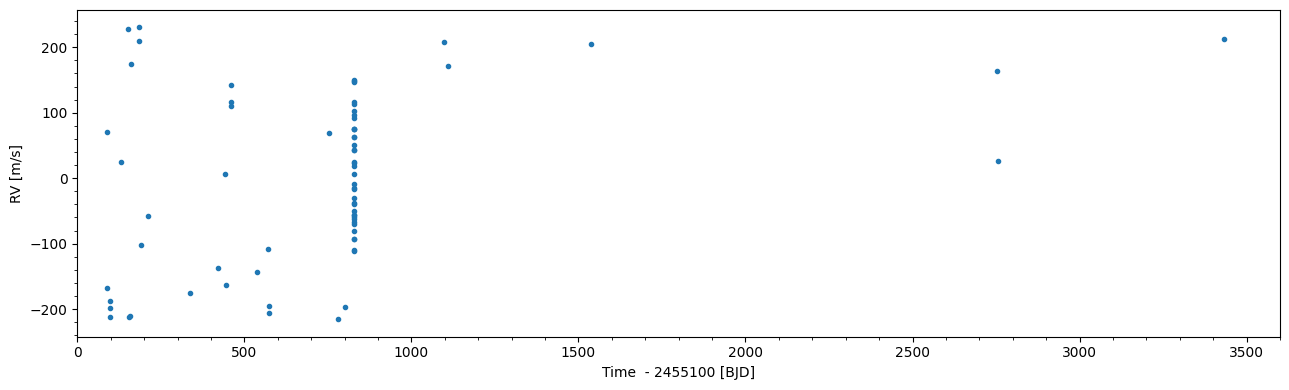

In [5]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
ax.minorticks_on()
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>

1. Try to describe the logic behind the time sampling of the RV observations.

- Answer: 

There can be many reasons as to why observations were carried out during multiple days.

One reason could be to have a good enough temporal sampling when the data are put in phase, that way the semiamplitude of the RVs can be properly measured and planets mass inferred. The period of the planet is almost one day, meaining that if one observes it in two consecutive days one will basically see the same thing. If the objective is to construct the whole phase curve one would need to observe during many days to catch the different stages of the stellar motion. Furthermore if this was not a transiting planet these measurements would allow the calculation of the orbital period, although not as precisely as in the case of transiting one. 

Moreover, if we were to see some deviation from the standard single sinusoidal form of the RV curve (for instance finding the presence of other sinusoidal components) we could infer the presence of other planets (or objects) in the system. 

One more thing to note is that some authors ([Maciejewski et al 2020](https://iopscience.iop.org/article/10.3847/1538-4357/ab5e87), and [Patra et al 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa6d75)) have found signs of decreasing period. Some other authors ([Weinberg et al. 2017](https://iopscience.iop.org/article/10.3847/2041-8213/aa9113/meta)) have suggested as explanation for this fact the possibility of orbital decay among other explanations, that is, the planet would be spiraling in towards Wasp-12. This would be reflected in the data as an RV curve which would seem to get shorter each time the planet orbits around the system's barycenter. Measuring this effect would require to make RV measurements in a timeline of months to be able to detect it.


2. Plot below the RV observations as a function of time focusing on the densely-sampled time-span: 

Shown below

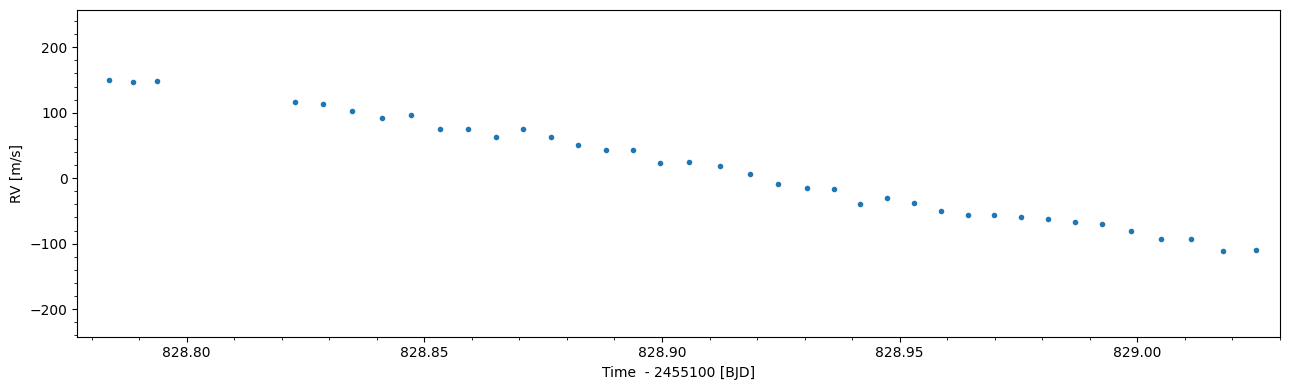

In [6]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.777, 829.03))
ax.minorticks_on()
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [7]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

Next, we use the `LombScargle.autopower` to calculate the periodogram. We restrict the search to $0.5 < P < 5$ days.

In [8]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [9]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

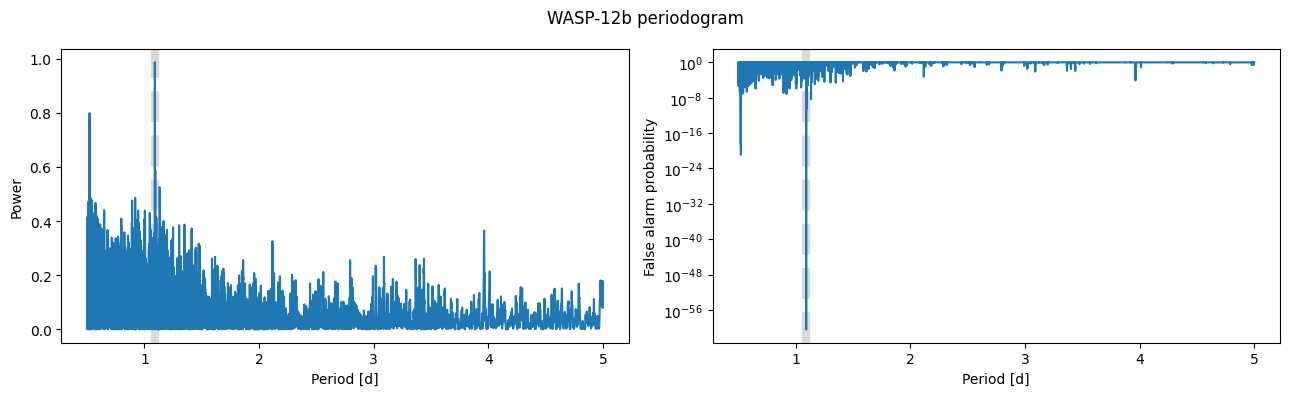

In [10]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

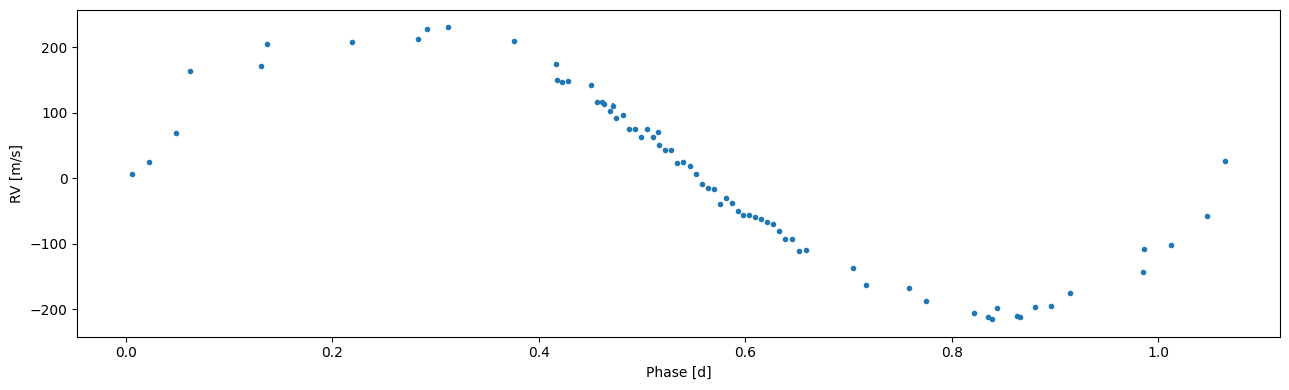

In [11]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [12]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

In [13]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

The parameters are

- `tc_1`: transit center [BJD]
- `p_1`: orbital period [d]
- `secw_1`: $\sqrt{e} \cos\omega$, where $e$ is the eccentricity and $\omega$ the argument of periastron
- `sesw_1`: $\sqrt{e} \sin\omega$
- `rv_shift_0`: systemic velocity [m/s]
- `rv_err_0`: additional white noise [m/s]
- `rv_k_1` RV semiamplitude [m/s]
- `rv_slope`: additional linear slope

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [14]:
lpf.set_prior('tc_1', 'NP', 2458480.65, 0.02) # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', best_period.value, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)

In [15]:
lpf.ps

[  0 |G| tc_1           N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0914499847447225, σ = 0.1)       [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/10000 [00:00<?, ?it/s]

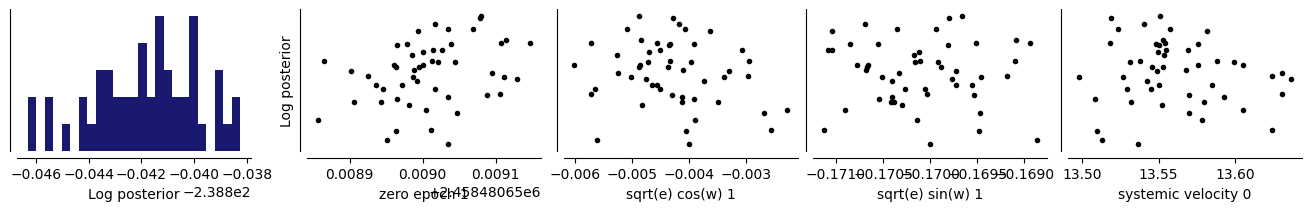

In [16]:
lpf.optimize_global(10000)

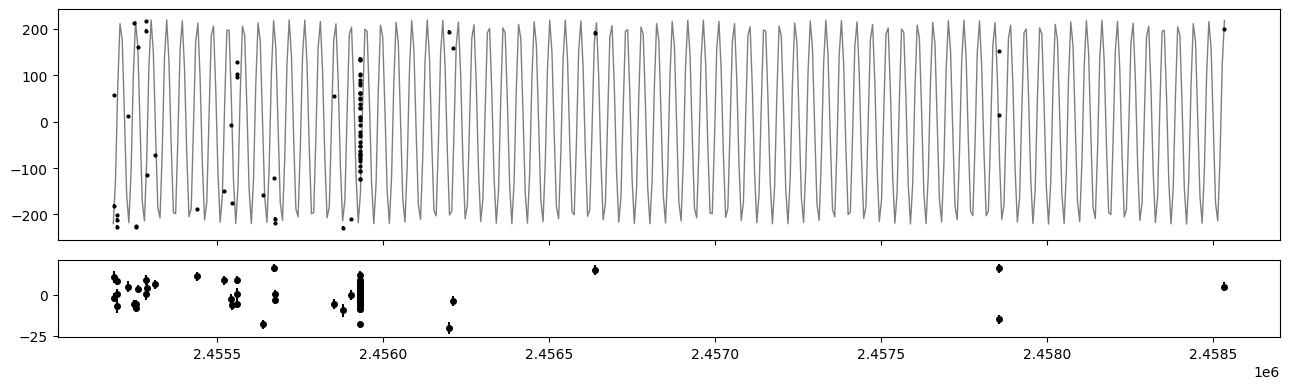

In [17]:
lpf.plot_rv_vs_time();

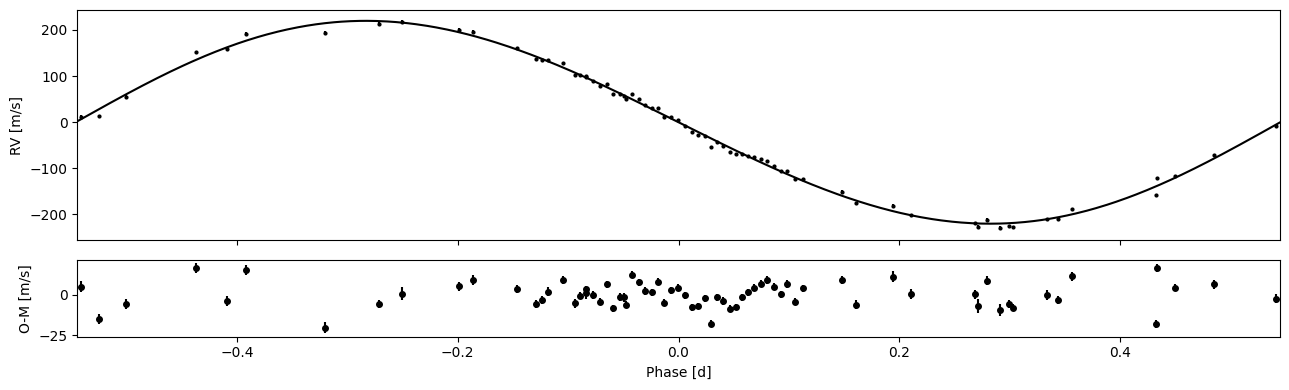

In [18]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [19]:
lpf.sample_mcmc(niter=5000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

The *emcee* sampler uses an ensemble of MCMC chains to sample the posterior. This means that we have many chains running in parallel. We can plot the traces of each chain to see how the chain population behaves in time.

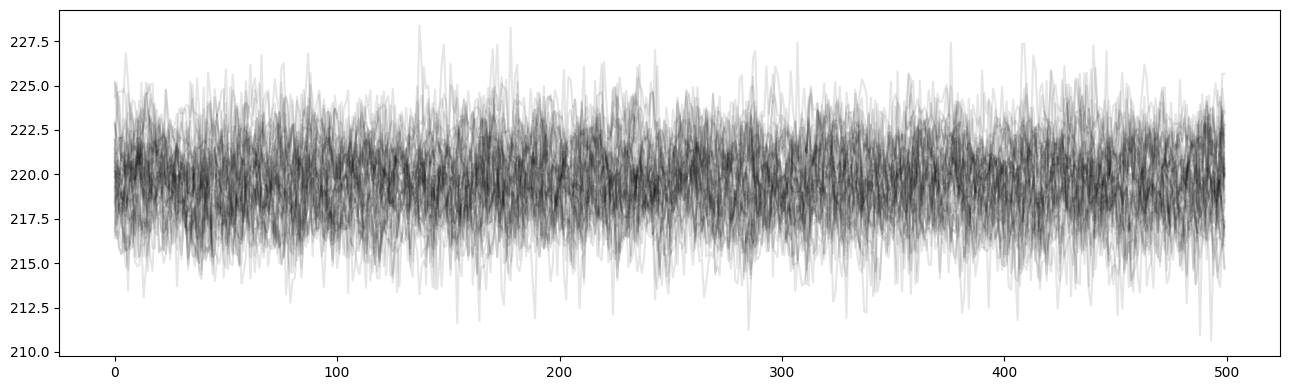

In [20]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

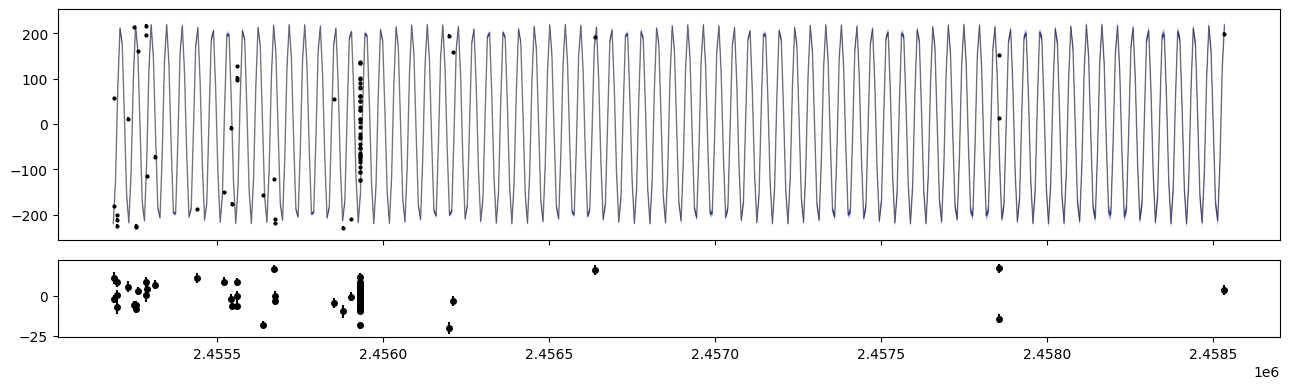

In [21]:
lpf.plot_rv_vs_time('mcmc');

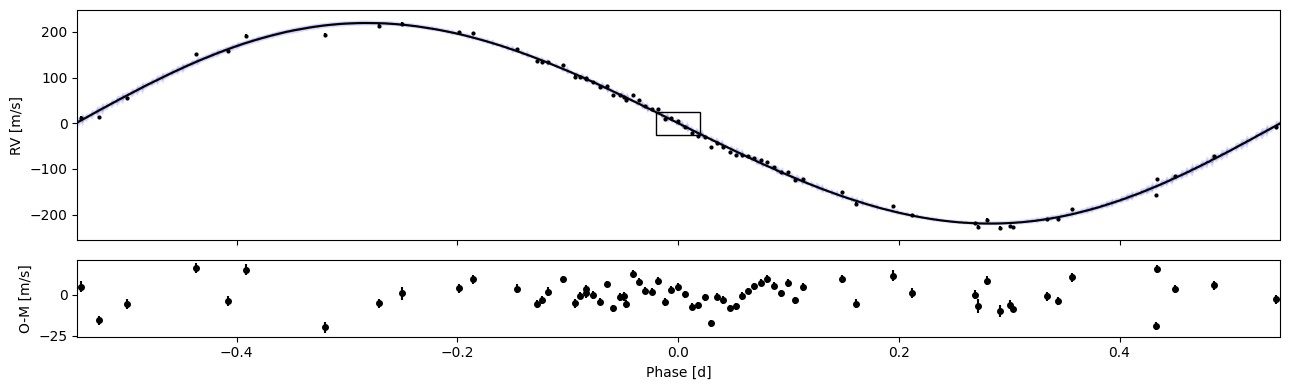

In [22]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

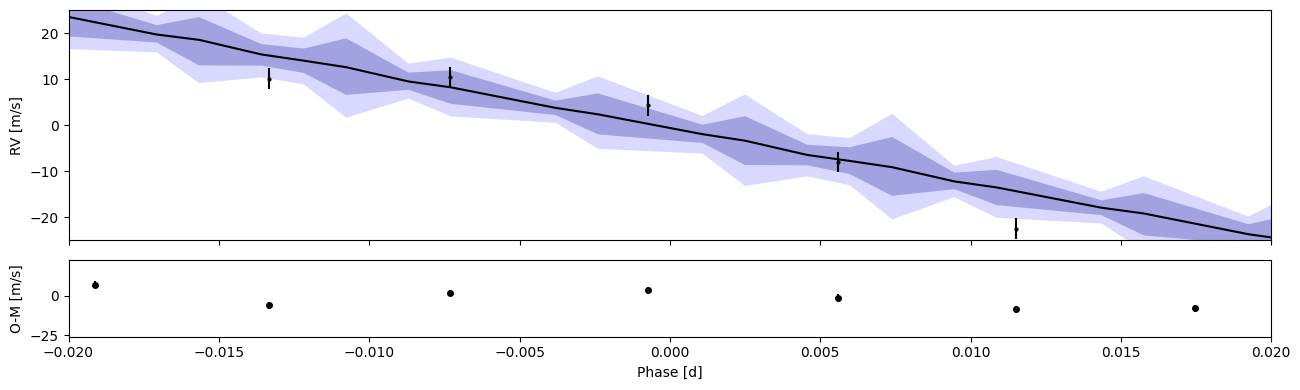

In [23]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [24]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,2.458481e+06,1.091422,-0.059721,-0.141530,11.960385,9.126593,218.396876,0.000035
1,2.458481e+06,1.091423,-0.024837,-0.162956,12.688283,8.626361,219.195091,-0.000753
2,2.458481e+06,1.091422,-0.029665,-0.184091,11.161332,9.527025,218.211773,-0.000937
3,2.458481e+06,1.091423,-0.008889,-0.170983,12.520921,9.362757,218.968705,0.000383
4,2.458481e+06,1.091421,-0.005535,-0.142001,11.726211,9.921442,216.189778,0.002707
...,...,...,...,...,...,...,...,...
24995,2.458481e+06,1.091423,-0.029153,-0.149586,13.011035,6.917537,217.187331,0.000362
24996,2.458481e+06,1.091424,-0.027051,-0.152856,13.017204,6.870261,216.935134,0.000619
24997,2.458481e+06,1.091422,-0.029970,-0.179277,15.462338,7.334177,219.847376,0.001835
24998,2.458481e+06,1.091424,0.027840,-0.158624,15.394851,7.189520,220.232187,0.004008


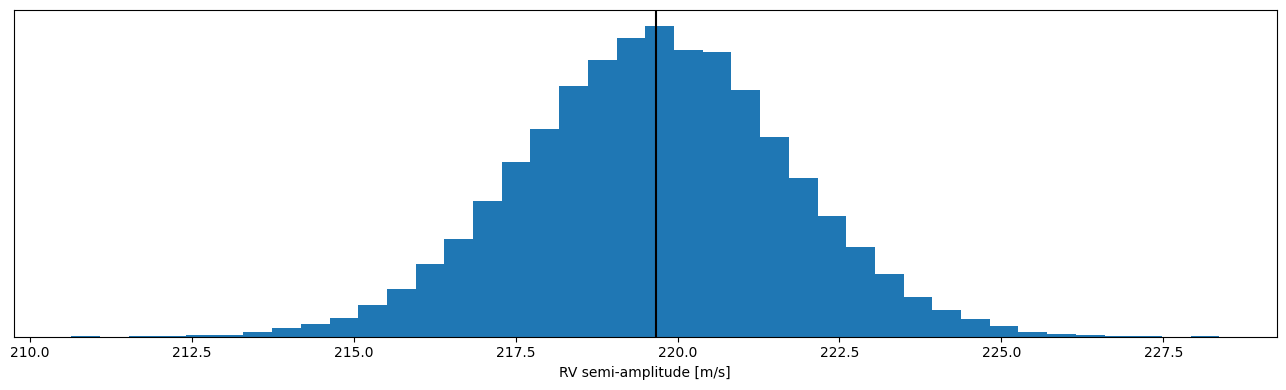

In [25]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

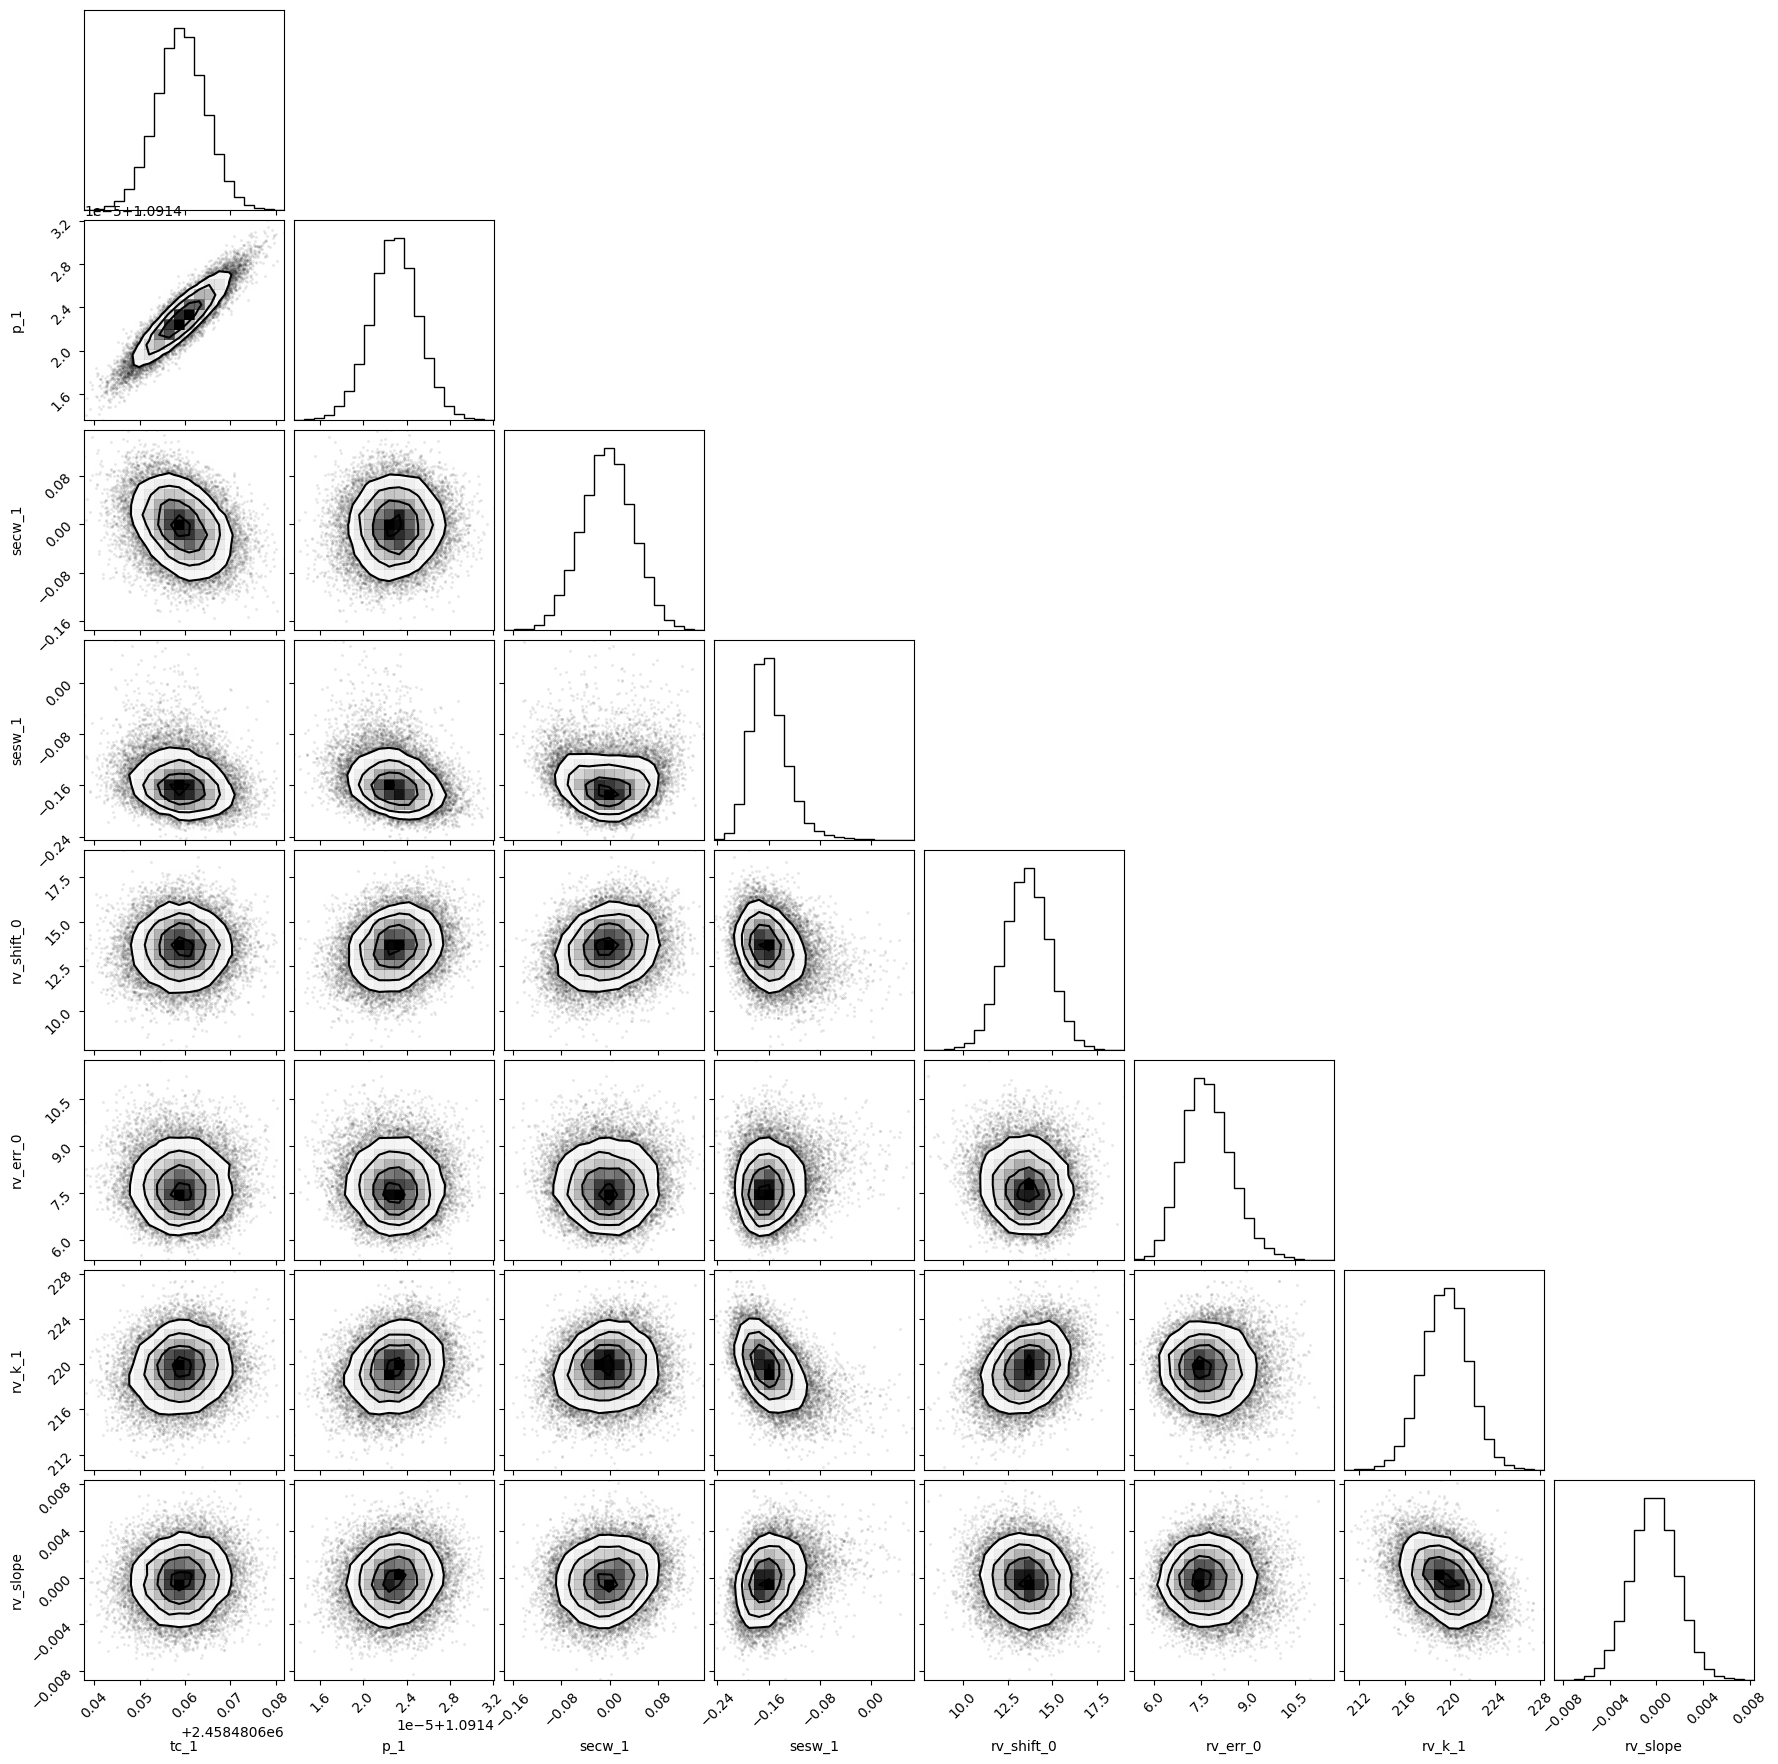

In [26]:
corner(df.values, labels=df.columns);

### <span style="color:darkblue">Questions and exercises</span>

1. What is the minimum mass ($m\sin i$) of WASP-12b assuming $e=0$? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.

- Answer.



2. What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

- Answer.



3. We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?

- Answer.



4. Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.

### <span style="color:darkblue">Answers to the exercises</span>

1. What is the minimum mass ($m\sin i$) of WASP-12b assuming $e=0$? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.

- Answer. 

In this case we would begin by setting $e=0$ in the semiamplitude equation.


$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}} \rightarrow K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}}
$$

So we would have the minimum mass be.

$$
M_\mathrm{p} \sin i = K\left(\frac{2\pi G}{P}\right)^{-1/3} (M_\star + M_\mathrm{p})^{2/3}
$$
Because $M_\star >> M_\mathrm{p}$ we can neglect the second term obtaining.

$$
M_\mathrm{p} \sin i = K\left(\frac{2\pi G}{P}\right)^{-1/3} M_\star^{2/3}
$$

Assuming a mass of $M_\star  = 1.25\,\mathrm{M_\odot}=2.5\times10^{30}\,\mathrm{kg}$ as detailed in the next exercise and $K = 219.6\,\mathrm{m\,s^{-1}}$ we obtain the following.



In [27]:
import numpy as np
from IPython.display import display, Markdown

G = 6.67*10**(-11)
#K_1 = median(df.rv_k_1)
#P_1 = median(df.p_1)*24*3600 # in seconds

K_1_dist = df.rv_k_1
P_1_dist = df.p_1*24*3600 

M_wasp_12 = 2.5*10**30
M_jupiter = 1.899*10**27
M_wasp_12b_e_0_dist = K_1_dist*(((2*np.pi*G)/(P_1_dist))**(-1/3))*M_wasp_12**(2/3)

M_wasp_12b_e_0 = median(M_wasp_12b_e_0_dist)/ M_jupiter

error_M_wasp_12b_e_0 = np.quantile(M_wasp_12b_e_0_dist,q=[0.16,0.5,0.84])
M_wasp_12b_e_0_upper_err = np.abs(median(M_wasp_12b_e_0_dist)-error_M_wasp_12b_e_0[-1])/ M_jupiter
M_wasp_12b_e_0_lower_err = np.abs(median(M_wasp_12b_e_0_dist)-error_M_wasp_12b_e_0[0])/ M_jupiter

string = "The minimum mass, $m\sin \,i$, of Wasp-12b in this case would be: {:.2f} $^{{+{:.2f}}}_{{-{:.2f}}}$ $\mathrm{{M_J}}$ ".format(M_wasp_12b_e_0,M_wasp_12b_e_0_upper_err,M_wasp_12b_e_0_lower_err)
display(Markdown(string))

The minimum mass, $m\sin \,i$, of Wasp-12b in this case would be: 1.30 $^{+0.01}_{-0.01}$ $\mathrm{M_J}$ 

2. What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

- Answer. 

Firstly the mass of Wasp-12, according to [Weinberg et al. 2017](https://iopscience.iop.org/article/10.3847/2041-8213/aa9113/meta), is $M_\star  \sim 1.3\,\mathrm{M_\odot} $ if it is a main sequence star or a $M_\star  \sim 1.2\,\mathrm{M_\odot} $ if it is a subgiant. Let us assume a mass of 1.25 for good measure. This equates to $\sim 2.5\times10^{30}\,\mathrm{kg}$. Taking $\mathrm{M_\oplus = 5.972\times 10^{24}\, kg}$, $\mathrm{P = 365\, d = 3.15\times 10^{7}\, s}$. Using $K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{\oplus} \sin i}{(M_\star)^{2/3}}
$ again and assuming $i=90^\circ$ for simplicity one would get $\boxed{K = 0.07\,\mathrm{{m/s}}}$. These results are similar to what an Earth-like planet around a Sun-like star would produce at 1 A.U. Table 1 of the following book chapter [Lovis, C. & Fischer, D.. (2011). Radial Velocity Techniques for Exoplanets. University of Arizona Press, 2011](http://exoplanets.astro.yale.edu/workshop/EPRV/Bibliography_files/Radial_Velocity.pdf)

3. & 4. We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?. Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.

- Answer. 

First let us look at the distributions of $\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$ to see if the median values are representative and to check there are no weird behaviours.


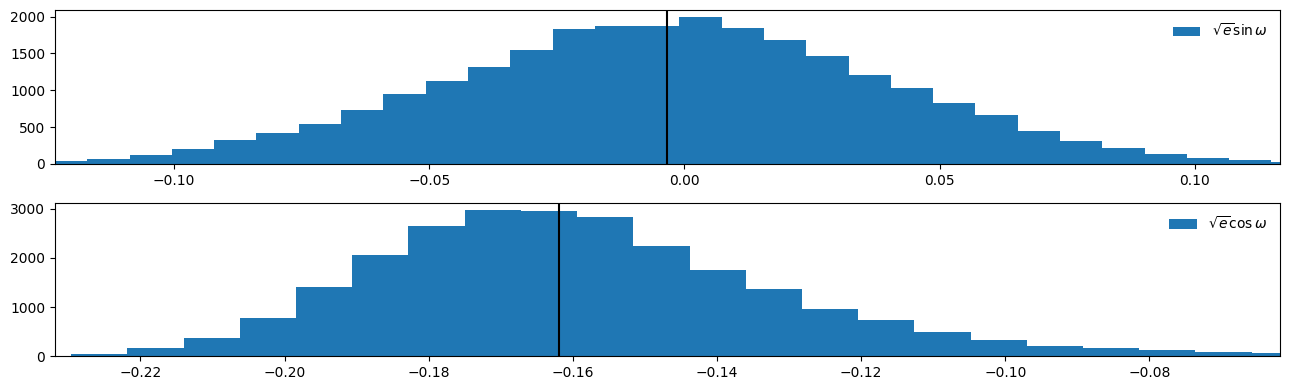

In [28]:
fig, (ax1, ax2) = subplots(2)

ax1.hist(df.secw_1, bins=40,label = r'$\sqrt{e}\sin\omega$')
ax1.axvline(median(df.secw_1), c='k')
ax1.set_xlim(median(df.secw_1)-0.12,median(df.secw_1)+0.12)
ax1.legend(frameon=False)



ax2.hist(df.sesw_1, bins=40,label = r'$\sqrt{e}\cos\omega$')
ax2.axvline(median(df.sesw_1), c='k')
ax2.legend(frameon=False)
ax2.set_xlim(median(df.sesw_1)-0.07,median(df.sesw_1)+0.10)
fig.tight_layout()

The median is representative of the distribution. So in this case we would have.

$$
\sqrt{e}\sin\omega = \alpha~;~\sqrt{e}\cos\omega = \beta
$$

Where $\alpha$ and $\beta$ are the different values the distribution can take. Isolating $\sqrt{e}$ one gets.

$$
\sqrt{e} = \frac{\beta}{\cos\omega}\rightarrow \frac{\beta}{\cos\omega} = \frac{\alpha}{\sin\omega}\rightarrow\omega = \arctan \left(\frac{\alpha}{\beta}\right) 
$$

This would then imply.

$$
e = \left(\frac{\beta}{\cos \omega}\right)^2  = \left(\frac{\beta}{\cos\arctan \left(\frac{\alpha}{\beta}\right)}\right)^2
$$

Or more simply 

$$
e = \alpha^2 +\beta^2
$$

The distributions would then be.

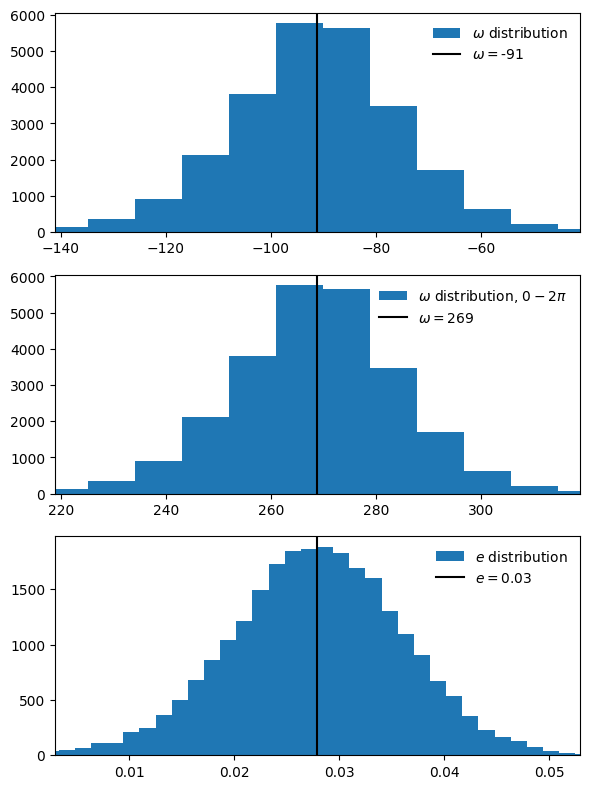

In [29]:
fig, (ax1, ax2, ax3) = subplots(3,figsize=(6, 8))



omega = np.arctan2(df.sesw_1,df.secw_1)*(180/np.pi) # this is in degrees
omega_0_2pi = 360+omega # this is in degrees
#omega = np.arctan(df.sesw_1/df.secw_1)*(180/np.pi) # this is in degrees -> degeneracy in this case?



ax1.hist(omega, bins=40,label = r'$\omega$ distribution')
ax1.axvline(median(omega), c='k',label = r'$\omega = $' + "{:.0f}".format(median(omega)))
ax1.legend(frameon=False)
ax1.set_xlim(median(omega)-50,median(omega)+50)



ax2.hist(omega_0_2pi, bins=40,label = r'$\omega$ distribution, $0-2\pi$')
ax2.axvline(median(omega_0_2pi), c='k',label = r'$\omega = $' + "{:.0f}".format(median(omega_0_2pi)))
ax2.legend(frameon=False)
ax2.set_xlim(median(omega_0_2pi)-50,median(omega_0_2pi)+50)

ecc = df.secw_1**2 + df.sesw_1**2 

ax3.hist(ecc, bins=40,label = r'$e$ distribution')
ax3.axvline(median(ecc), c='k',label = r'$e = $' + "{:.2f}".format(median(ecc)))
ax3.legend(frameon=False)
ax3.set_xlim(median(ecc)-0.025,median(ecc)+0.025)
fig.tight_layout()


error_omega=np.quantile(omega,q=[0.16,0.5,0.84])
error_ecc=np.quantile(ecc,q=[0.16,0.5,0.84])


Looking at the corner plot we can see that distributions do not show major correlations. Because the distributions are normal let us assume that a conservative error can be given as a $\sigma$ deviation from the median. In this case the results obtained for the eccentricy and argument of periastron are  

In [30]:
omega_upper_err = np.abs(median(omega)-error_omega[-1])
omega_lower_err = np.abs(median(omega)-error_omega[0])
string = "The argument of periastron, $\omega$, is: {:2.0f} $^{{+{:.0f}}}_{{-{:.0f}}}$ degrees".format(median(omega), omega_upper_err, omega_lower_err)
display(Markdown(string))


ecc_upper_err = np.abs(median(ecc)-error_ecc[-1])
ecc_lower_err = np.abs(median(ecc)-error_ecc[0])
string = "The eccentricity, $e$, is: {:2.2f} $^{{+{:.2f}}}_{{-{:.2f}}}$".format(median(ecc), ecc_upper_err, ecc_lower_err)
display(Markdown(string))


The argument of periastron, $\omega$, is: -91 $^{+15}_{-16}$ degrees

The eccentricity, $e$, is: 0.03 $^{+0.01}_{-0.01}$

Both of which are close to those found in Table 3 of [Hebb et al (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920)

Now the angle of periastron in the range $0-2\pi$ is.

In [31]:
string = "The argument of periastron, $\omega$, is: {:2.0f} $^{{+{:.0f}}}_{{-{:.0f}}}$ degrees".format(360+median(omega), omega_upper_err, omega_lower_err)
display(Markdown(string))

The argument of periastron, $\omega$, is: 269 $^{+15}_{-16}$ degrees

---

<center>&copy;2024 Hannu Parviainen</center>